In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


In [223]:
filename = "ah25_long.csv"
#filename = "ah78_long.csv"
#filename = "ah78_month.csv"
#filename = "ah78_week.csv"

ts = pd.read_csv(filename)

ts["mydate"] = pd.to_datetime(ts.mydate)
ts = ts.set_index("mydate")
ts["yy"] = ts.y.interpolate()
ts.describe()


,y,a,b,c,h,yy
count,94853.000000,96190.000000,96190.000000,96190.000000,44824.000000,96190.000000
mean,5.968162,1.944888,0.130746,0.523713,76.658562,5.969036
std,1.583245,4.936025,0.376549,3.997753,11.548074,1.581908
min,2.164790,0.000000,0.000000,0.000000,41.000000,2.164790
25%,4.829150,0.000000,0.000000,0.000000,69.000000,4.829150
50%,5.661760,0.486000,0.050000,0.000000,75.000000,5.661760
75%,6.827420,1.992000,0.100000,0.000000,82.000000,6.827420
max,17.040800,110.701000,7.000000,110.000000,192.000000,17.040800


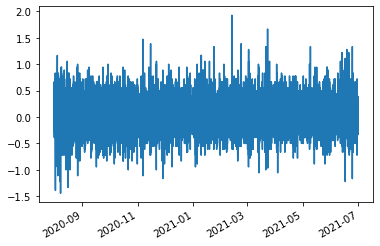

In [224]:
ts.index = pd.DatetimeIndex(ts.index.values, freq="5min")
#train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)

ts["dy"] = ts["yy"].diff(1)
ts["dy"].plot()
plt.show()


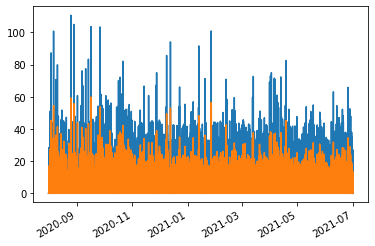

In [225]:
ts["A"] = ts["a"].ewm(halflife='5 min', times=pd.DatetimeIndex(ts.index)).mean()
ts.a.plot()
ts.A.plot()
plt.show()
#ts.describe()


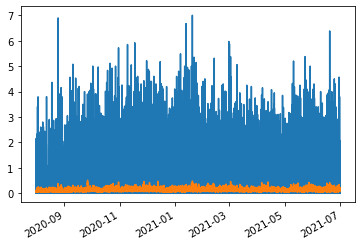

In [226]:
ts["B"] = ts["b"].ewm(halflife='2 hours', times=pd.DatetimeIndex(ts.index)).mean()
ts.b.plot()
ts.B.plot()
plt.show()
#ts.describe()


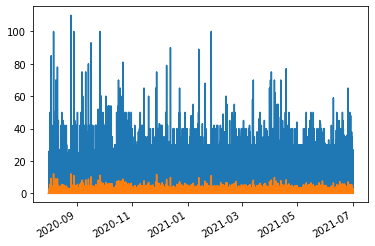

In [227]:
ts["C"] = ts["c"].ewm(halflife='30 min', times=pd.DatetimeIndex(ts.index)).mean()
ts.c.plot()
ts.C.plot()
plt.show()
#ts.describe()


In [228]:
ts["night"] = True 
ts.loc[ts.between_time('06:00','23:59').index,"night"] = False
ts.head()


,y,a,b,c,h,yy,dy,A,B,C,night
2020-08-01 00:08:06,7.27148,0.0,0.059524,0.0,NaN,7.27148,NaN,0.0,0.059524,0.0,True
2020-08-01 00:13:06,7.21597,0.0,0.059524,0.0,NaN,7.21597,-0.05551,0.0,0.059524,0.0,True
2020-08-01 00:18:06,7.27148,0.0,0.059524,0.0,NaN,7.27148,0.05551,0.0,0.059524,0.0,True
2020-08-01 00:23:06,7.27148,0.0,0.209524,0.0,NaN,7.27148,0.00000,0.0,0.098664,0.0,True
2020-08-01 00:28:06,7.21597,0.0,0.011905,0.0,NaN,7.21597,-0.05551,0.0,0.080295,0.0,True


In [229]:
ts["hypo"] = ts["yy"] < 4
ts.hypo.sum()


5441

In [230]:
ts["dips"] = ts.hypo & ts.night
ts.dips.sum()


1366

In [231]:
ts["twos"] = False
ts.loc[ts.index[1:], "twos"] = ts.dips.values[1:] & ts.dips.values[:-1]
ts.twos.sum()


1193

In [232]:
ts["tres"] = False
ts.loc[ts.index[1:-1], "tres"] = ts.dips.values[:-2] & ts.dips.values[1:-1] & ts.dips.values[2:]
ts.tres.sum()


1033

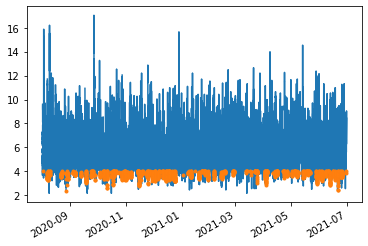

In [233]:
ts["y"].plot()
plt.plot(ts.loc[ts.dips, "y"],'.')
plt.show()


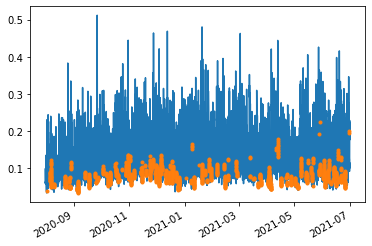

In [234]:
ts.B.plot()
plt.plot(ts.loc[ts.dips, "B"],'.')
plt.show()


In [235]:
ts["fp"] = (ts.B < 0.2) & ts.dips
ts["tp"] = (ts.B > 0.2) & ts.dips
ts.fp.sum(), ts.tp.sum()


(1364, 2)

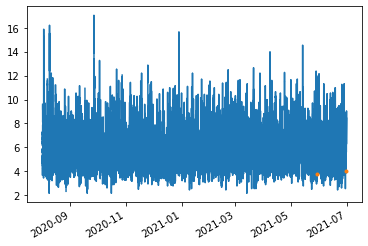

In [236]:
ts["y"].plot()
plt.plot(ts.loc[ts.tp, "y"],'.')
plt.show()


In [237]:
ts.to_csv("simple_" + filename)


3